# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing needed libraries


In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Viewing data before any cleaning
*All the data checking is made on profile, portfolio and  transcript datasets*
* Check on columns types and data types
* Check on numerical values
* Check on null rows
* Check ids used in offer types
* Plot histogram of income amounts
* Plot gender transactions
* Check on extremes in data


In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
len(portfolio)

10

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
np.sum(portfolio.isna())

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio.groupby('offer_type')['id'].value_counts()

offer_type     id                              
bogo           4d5c57ea9a6940dd891ad53e9dbe8da0    1
               9b98b8c7a33c4b65b9aebfe6a799e6d9    1
               ae264e3637204a6fb9bb56bc8210ddfd    1
               f19421c1d4aa40978ebb69ca19b0e20d    1
discount       0b1e1539f2cc45b7b9fa7c272da2e1d7    1
               2298d6c36e964ae4a3e7e9706d1fb8c2    1
               2906b810c7d4411798c6938adc9daaa5    1
               fafdcd668e3743c1bb461111dcafc2a4    1
informational  3f207df678b143eea3cee63160fa8bed    1
               5a8bc65990b245e5a138643cd4eb9837    1
Name: id, dtype: int64

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
len(profile)

17000

In [11]:
np.sum(profile.isna())

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [12]:
profile['id'].nunique()

17000

In [13]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

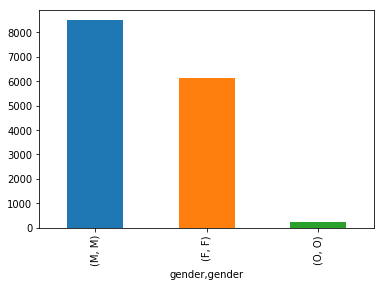

In [14]:
profile.groupby('gender')['gender'].value_counts().sort_values(ascending=False).plot(kind='bar')

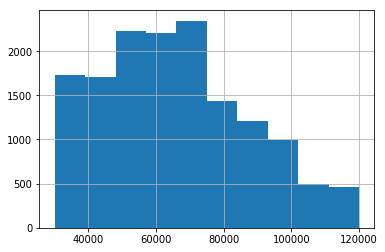

In [15]:
profile['income'].hist()

In [16]:
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

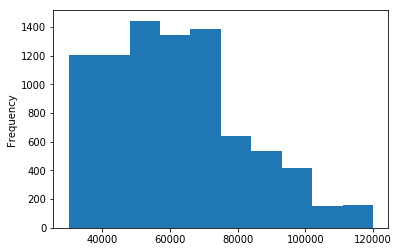

In [17]:
profile[(profile['gender']=='M')&(profile['age']!=118)]['income'].plot(kind='hist')

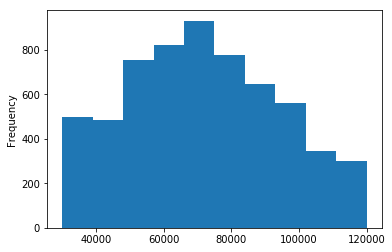

In [18]:
profile[(profile['gender']=='F')&(profile['age']!=118)]['income'].plot(kind='hist')

## Transcript dataset viewing


In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
df_transaction = transcript[transcript['event'] == 'transaction']

In [25]:
df_transaction.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


# Starting data cleaning
### Protfolio dataset:
* Converting duration columns from days to hours
* Use MinMaxScaler on difficulty and duration columns
* Create 4 new columns based on channels used in the offer,  1 if the channels columns else 0
* Create a map for offer_id it could be done with two methods first with dicts, the final one with LabelEncoder


In [26]:
portfolio_cleaned=portfolio.copy()

In [27]:
portfolio_cleaned.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [28]:
portfolio_cleaned['duration']=portfolio_cleaned['duration']*24

In [29]:
portfolio_cleaned.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [30]:
minmax_scaler=MinMaxScaler()
portfolio_cleaned[['difficulty','reward']]=minmax_scaler.fit_transform(portfolio_cleaned[['difficulty','reward']])
portfolio_cleaned.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0
1,"[web, email, mobile, social]",0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0
2,"[web, email, mobile]",0.00,96,3f207df678b143eea3cee63160fa8bed,informational,0.0
3,"[web, email, mobile]",0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5
4,"[web, email]",1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5


In [31]:
portfolio_cleaned['channel_email']=portfolio_cleaned['channels'].apply(lambda x:1 if 'email' in x else 0)

In [32]:
portfolio_cleaned['channel_web']=portfolio_cleaned['channels'].apply(lambda x:1 if 'web' in x else 0)

In [33]:
portfolio_cleaned['channel_mobile']=portfolio_cleaned['channels'].apply(lambda x:1 if 'mobile' in x else 0)

In [34]:
portfolio_cleaned['channel_social']=portfolio_cleaned['channels'].apply(lambda x:1 if 'social' in x else 0)

In [35]:
portfolio_cleaned.drop('channels',inplace=True,axis=1)
portfolio_cleaned.head()

,difficulty,duration,id,offer_type,reward,channel_email,channel_web,channel_mobile,channel_social
0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1.0,1,0,1,1
1,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1.0,1,1,1,1
2,0.00,96,3f207df678b143eea3cee63160fa8bed,informational,0.0,1,1,1,0
3,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.5,1,1,1,0
4,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.5,1,1,0,0


In [36]:
portfolio_cleaned.rename(columns={'id':'offer_id'},inplace=True)


In [37]:
labels_offer_id = portfolio_cleaned['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}

In [38]:
replace_map_comp_offer_id

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [39]:
portfolio_cleaned.replace(replace_map_comp_offer_id, inplace=True)
portfolio_cleaned.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_web,channel_mobile,channel_social
0,0.50,168,8,bogo,1.0,1,0,1,1
1,0.50,120,5,bogo,1.0,1,1,1,1
2,0.00,96,4,informational,0.0,1,1,1,0
3,0.25,168,7,bogo,0.5,1,1,1,0
4,1.00,240,1,discount,0.5,1,1,0,0


In [40]:
labels_offer_type = portfolio_cleaned['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}


In [41]:
portfolio_cleaned.replace(replace_map_comp_offer_type, inplace=True)

In [42]:
replace_map_comp_offer_type

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}

In [43]:
portfolio_cleaned.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_web,channel_mobile,channel_social
0,0.50,168,8,1,1.0,1,0,1,1
1,0.50,120,5,1,1.0,1,1,1,1
2,0.00,96,4,3,0.0,1,1,1,0
3,0.25,168,7,1,0.5,1,1,1,0
4,1.00,240,1,2,0.5,1,1,0,0


In [44]:
portfolio_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
difficulty        10 non-null float64
duration          10 non-null int64
offer_id          10 non-null int64
offer_type        10 non-null int64
reward            10 non-null float64
channel_email     10 non-null int64
channel_web       10 non-null int64
channel_mobile    10 non-null int64
channel_social    10 non-null int64
dtypes: float64(2), int64(7)
memory usage: 800.0 bytes


In [45]:
portfolio_cleaned.rename(columns={'id':'offer_id'},inplace=True)

### Profile dataset
* Rename id to cust_id to help in joining process later
* Clean age 118 values
* Create bins for each age group
* Create bins for each income range
* Create new features from date column as Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end and Is_year_start
* Calculate how long the user is a member of starbucks
* Remove containing null rows for age 118



In [46]:
profile_cleaned = profile.copy()

In [47]:
profile_cleaned.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [48]:
profile_cleaned.rename(columns={'id':'cust_id'},inplace=True)

In [49]:
profile_cleaned.columns

Index(['age', 'became_member_on', 'gender', 'cust_id', 'income'], dtype='object')

In [50]:
profile_cleaned=profile_cleaned.reindex(columns=['cust_id','age','income','became_member_on','gender'])

In [51]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,20170212,None
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,20170715,F
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,20180712,None
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,20170509,F
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,20170804,None


In [52]:
labels_customer=profile_cleaned['cust_id'].astype('category').cat.categories.tolist()

replace_map_label_customer = {'cust_id':{k: v for k,v in zip(labels_customer,list(range(1,len(labels_customer)+1)))}} 

In [53]:
profile_cleaned.replace(replace_map_label_customer,inplace=True)

In [54]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender
0,6962,118,NaN,20170212,None
1,399,55,112000.0,20170715,F
2,3747,118,NaN,20180712,None
3,7997,75,100000.0,20170509,F
4,10736,118,NaN,20170804,None


In [55]:
profile_cleaned['age']=profile_cleaned['age'].apply(lambda x: np.nan if x==118 else x)

In [56]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender
0,6962,NaN,NaN,20170212,None
1,399,55.0,112000.0,20170715,F
2,3747,NaN,NaN,20180712,None
3,7997,75.0,100000.0,20170509,F
4,10736,NaN,NaN,20170804,None


In [57]:
profile_cleaned[profile_cleaned['age']==118]

,cust_id,age,income,became_member_on,gender


In [58]:
profile_cleaned.dropna(axis=0,how='any',inplace=True)

In [59]:
profile_cleaned[['age','income']]=profile_cleaned[['age','income']].astype(int)

In [60]:
profile_cleaned

,cust_id,age,income,became_member_on,gender
1,399,55,112000,20170715,F
3,7997,75,100000,20170509,F
5,15044,68,70000,20180426,M
8,3729,65,53000,20180209,M
12,3060,58,51000,20171111,M
13,11411,61,57000,20170911,F
14,14985,26,46000,20140213,M
15,3275,62,71000,20160211,F
16,6547,49,52000,20141113,M
18,6657,57,42000,20171231,M


In [61]:
profile_cleaned['age_group']=pd.cut(profile_cleaned['age'],bins=[17, 22, 35, 60, 103],
                                    labels=['Teenager','Youth','Adult','Elderly'])
profile_cleaned['age_group'].head()

1       Adult
3     Elderly
5     Elderly
8     Elderly
12      Adult
Name: age_group, dtype: category
Categories (4, object): [Teenager < Youth < Adult < Elderly]

In [62]:
labels_age_grp=profile_cleaned['age_group'].astype('category').cat.categories.tolist()
replace_map_age_grp={'age_group':{k:v for k,v in zip(labels_age_grp,list(range(1,len(labels_age_grp)+1)))}}

In [63]:
replace_map_age_grp

{'age_group': {'Teenager': 1, 'Youth': 2, 'Adult': 3, 'Elderly': 4}}

In [64]:
profile_cleaned.replace(replace_map_age_grp,inplace=True)

In [65]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group
1,399,55,112000,20170715,F,3
3,7997,75,100000,20170509,F,4
5,15044,68,70000,20180426,M,4
8,3729,65,53000,20180209,M,4
12,3060,58,51000,20171111,M,3


In [66]:
profile_cleaned['income_range'] = pd.cut(profile_cleaned['income'], bins=[29999, 60000, 90000, 120001],
                                         labels=['average', 'above-average', 'high'])

In [67]:
labels_income_range = profile_cleaned['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range = {'income_range' : {k: v for k,v in zip(labels_income_range,
                                                                       list(range(1,len(labels_income_range)+1)))}}

In [68]:
replace_map_comp_income_range

{'income_range': {'average': 1, 'above-average': 2, 'high': 3}}

In [69]:
profile_cleaned['income_range'].value_counts()

average          6693
above-average    5938
high             2194
Name: income_range, dtype: int64

In [70]:
profile_cleaned.replace(replace_map_comp_income_range,inplace=True)

In [71]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range
1,399,55,112000,20170715,F,3,3
3,7997,75,100000,20170509,F,4,3
5,15044,68,70000,20180426,M,4,2
8,3729,65,53000,20180209,M,4,1
12,3060,58,51000,20171111,M,3,1


In [72]:
le=LabelEncoder()


In [73]:
profile_cleaned['gender_cleaned']=le.fit_transform(profile_cleaned['gender'])
np.save('classes_gender.npy', le.classes_)

In [74]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned
1,399,55,112000,20170715,F,3,3,0
3,7997,75,100000,20170509,F,4,3,0
5,15044,68,70000,20180426,M,4,2,1
8,3729,65,53000,20180209,M,4,1,1
12,3060,58,51000,20171111,M,3,1,1


In [75]:
profile_cleaned['became_member_on']=pd.to_datetime(profile_cleaned['became_member_on'],format='%Y%m%d')

In [76]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned
1,399,55,112000,2017-07-15,F,3,3,0
3,7997,75,100000,2017-05-09,F,4,3,0
5,15044,68,70000,2018-04-26,M,4,2,1
8,3729,65,53000,2018-02-09,M,4,1,1
12,3060,58,51000,2017-11-11,M,3,1,1


In [77]:
import re
def add_datepart(df, fldname, drop=True):
    '''
    INPUT:
        df DataFrame : the containg datafframe that will add new date features to it
        dlfname (str): string containg date column that will extract features from
        drop (bool) : drop date feature after cleaning dataset
    OUTPUT:
        the input df with new date feature as year star, day of week etc.
    '''
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
add_datepart(profile_cleaned,'became_member_on',drop=False)
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,...,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,became_member_onElapsed
1,399,55,112000,2017-07-15,F,3,3,0,2017,7,...,15,5,196,False,False,False,False,False,False,1500076800
3,7997,75,100000,2017-05-09,F,4,3,0,2017,5,...,9,1,129,False,False,False,False,False,False,1494288000
5,15044,68,70000,2018-04-26,M,4,2,1,2018,4,...,26,3,116,False,False,False,False,False,False,1524700800
8,3729,65,53000,2018-02-09,M,4,1,1,2018,2,...,9,4,40,False,False,False,False,False,False,1518134400
12,3060,58,51000,2017-11-11,M,3,1,1,2017,11,...,11,5,315,False,False,False,False,False,False,1510358400


In [78]:
import datetime
profile_cleaned['member_ship_days']=datetime.datetime.today().date() - profile_cleaned['became_member_on'].dt.date

In [79]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,...,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,became_member_onElapsed,member_ship_days
1,399,55,112000,2017-07-15,F,3,3,0,2017,7,...,5,196,False,False,False,False,False,False,1500076800,1000 days
3,7997,75,100000,2017-05-09,F,4,3,0,2017,5,...,1,129,False,False,False,False,False,False,1494288000,1067 days
5,15044,68,70000,2018-04-26,M,4,2,1,2018,4,...,3,116,False,False,False,False,False,False,1524700800,715 days
8,3729,65,53000,2018-02-09,M,4,1,1,2018,2,...,4,40,False,False,False,False,False,False,1518134400,791 days
12,3060,58,51000,2017-11-11,M,3,1,1,2017,11,...,5,315,False,False,False,False,False,False,1510358400,881 days


In [80]:
profile_cleaned['member_ship_days']=profile_cleaned['member_ship_days'].dt.days

In [81]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,...,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,became_member_onElapsed,member_ship_days
1,399,55,112000,2017-07-15,F,3,3,0,2017,7,...,5,196,False,False,False,False,False,False,1500076800,1000
3,7997,75,100000,2017-05-09,F,4,3,0,2017,5,...,1,129,False,False,False,False,False,False,1494288000,1067
5,15044,68,70000,2018-04-26,M,4,2,1,2018,4,...,3,116,False,False,False,False,False,False,1524700800,715
8,3729,65,53000,2018-02-09,M,4,1,1,2018,2,...,4,40,False,False,False,False,False,False,1518134400,791
12,3060,58,51000,2017-11-11,M,3,1,1,2017,11,...,5,315,False,False,False,False,False,False,1510358400,881


In [82]:
profile_cleaned['member_type'] = pd.cut(profile_cleaned['member_ship_days'],
                                        bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

In [83]:


# replacing the 'member_type' categorical labels by numerical labels
labels_member_type = profile_cleaned['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type = {'member_type' : {k: v for k,v in zip(labels_member_type,list(range(1,len(labels_member_type)+1)))}}



In [84]:
replace_map_comp_member_type

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}

In [85]:
profile_cleaned.replace(replace_map_comp_member_type, inplace=True)

In [86]:
profile_cleaned.head()

,cust_id,age,income,became_member_on,gender,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,...,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,became_member_onElapsed,member_ship_days,member_type
1,399,55,112000,2017-07-15,F,3,3,0,2017,7,...,196,False,False,False,False,False,False,1500076800,1000,1
3,7997,75,100000,2017-05-09,F,4,3,0,2017,5,...,129,False,False,False,False,False,False,1494288000,1067,2
5,15044,68,70000,2018-04-26,M,4,2,1,2018,4,...,116,False,False,False,False,False,False,1524700800,715,1
8,3729,65,53000,2018-02-09,M,4,1,1,2018,2,...,40,False,False,False,False,False,False,1518134400,791,1
12,3060,58,51000,2017-11-11,M,3,1,1,2017,11,...,315,False,False,False,False,False,False,1510358400,881,1


In [87]:
profile_cleaned.drop(columns = ['age','income','became_member_on', 'member_ship_days','became_member_onElapsed'], axis=1, inplace=True)

In [88]:
profile_cleaned.head()

,cust_id,gender,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,became_member_onWeek,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,member_type
1,399,F,3,3,0,2017,7,28,15,5,196,False,False,False,False,False,False,1
3,7997,F,4,3,0,2017,5,19,9,1,129,False,False,False,False,False,False,2
5,15044,M,4,2,1,2018,4,17,26,3,116,False,False,False,False,False,False,1
8,3729,M,4,1,1,2018,2,6,9,4,40,False,False,False,False,False,False,1
12,3060,M,3,1,1,2017,11,45,11,5,315,False,False,False,False,False,False,1


In [89]:
profile_cleaned.drop(columns = ['gender'], axis=1, inplace=True)

### Transcript Dataset

* First creat a copy of original dataset
* Replace column name person with cust_id for mergeing process
* Iterate over keys of value column to splir between offer_id, offer id, amount ,reward
* Create 3 new columns based on amount and offer_id and reward
* Transfrom event column and save it's transformation
* Remove reward and transction values from event column as we will develop model to predict if the user will view offer or consume offer
* Transform offer values



In [90]:
transcript_cleaned=transcript.copy()

In [91]:
transcript_cleaned.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [92]:
transcript_cleaned.rename(columns={'person':'cust_id'},inplace=True)

In [93]:
transcript_cleaned.replace(replace_map_label_customer,inplace=True)

In [94]:
transcript_cleaned.head()

,event,cust_id,time,value
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [95]:
keys=[]

for idx,row in transcript_cleaned.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
            

In [96]:
keys

['offer id', 'amount', 'offer_id', 'reward']

In [97]:
transcript_cleaned['offer_id']=''
transcript_cleaned['amount']=0
transcript_cleaned['reward']=0

In [98]:
for idx,row in transcript_cleaned.iterrows():
    for j in row['value']:
        if j=='offer id' or j=='offer_id':
            transcript_cleaned.at[idx,'offer_id']=row['value'][j]
            
        elif j=='amount':
            transcript_cleaned.at[idx,'amount']=row['value'][j]
            
        elif j=='reward':
            transcript_cleaned.at[idx,'reward']=row['value'][j]

            
            

In [99]:
transcript_cleaned['offer_id']=transcript_cleaned['offer_id'].apply(lambda x: 'N/A' if x=='' else x)

In [100]:
transcript_cleaned.head()

,event,cust_id,time,value,offer_id,amount,reward
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [101]:
transcript_cleaned.drop('value',axis=1,inplace=True)

In [102]:
transcript_cleaned.groupby('offer_id').count()

,event,cust_id,time,amount,reward
offer_id,,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,13751,13751,13751,13751,13751
2298d6c36e964ae4a3e7e9706d1fb8c2,20139,20139,20139,20139,20139
2906b810c7d4411798c6938adc9daaa5,15767,15767,15767,15767,15767
3f207df678b143eea3cee63160fa8bed,11761,11761,11761,11761,11761
4d5c57ea9a6940dd891ad53e9dbe8da0,18222,18222,18222,18222,18222
5a8bc65990b245e5a138643cd4eb9837,14305,14305,14305,14305,14305
9b98b8c7a33c4b65b9aebfe6a799e6d9,16202,16202,16202,16202,16202
N/A,138953,138953,138953,138953,138953
ae264e3637204a6fb9bb56bc8210ddfd,18062,18062,18062,18062,18062


In [103]:
transcript_cleaned['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [104]:
transcript_cleaned=transcript_cleaned[transcript_cleaned['event']!='transaction']
transcript_cleaned=transcript_cleaned[transcript_cleaned['event']!='offer received']


In [105]:
transcript_cleaned['event'].value_counts()

offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [106]:
transcript_cleaned['event_cleaned']=le.fit_transform(transcript_cleaned['event'])
np.save('classes_event.npy', le.classes_)

In [107]:
transcript_cleaned.head()

,event,cust_id,time,offer_id,amount,reward,event_cleaned
12650,offer viewed,3729,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1
12651,offer viewed,13995,0,5a8bc65990b245e5a138643cd4eb9837,0,0,1
12652,offer viewed,1052,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,1
12653,offer viewed,170,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1
12655,offer viewed,12744,0,5a8bc65990b245e5a138643cd4eb9837,0,0,1


In [108]:
transcript_cleaned.replace(replace_map_comp_offer_id,inplace=True)

In [109]:
transcript_cleaned.head()

,event,cust_id,time,offer_id,amount,reward,event_cleaned
12650,offer viewed,3729,0,9,0,0,1
12651,offer viewed,13995,0,6,0,0,1
12652,offer viewed,1052,0,5,0,0,1
12653,offer viewed,170,0,8,0,0,1
12655,offer viewed,12744,0,6,0,0,1


### Merged Dataframe
* Create a new df merged between transcript and portfolio based on offer_id
* Merge the new df with profile to get user data
* Check for null values
* Remove null values
* Transform event as it will be our target and save values from this transformation
* Data visualization plot count of transction based on income , gender, offer type and year of joining
* Transform age-group column and save it for later use
* Calculate how many offer compeleted for females and males
* Generate predictive model to predict if the user will complete an offer or will just view it

In [110]:
merged_df=transcript_cleaned.merge(portfolio_cleaned,how='left',on='offer_id')

In [111]:
merged_df=merged_df.merge(profile_cleaned,how='left',on='cust_id')

In [112]:
merged_df.head()

,event,cust_id,time,offer_id,amount,reward_x,event_cleaned,difficulty,duration,offer_type,...,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,member_type
0,offer viewed,3729,0,9,0,0,1,0.25,120,1,...,9.0,4.0,40.0,False,False,False,False,False,False,1.0
1,offer viewed,13995,0,6,0,0,1,0.00,72,3,...,16.0,5.0,259.0,False,False,False,False,False,False,1.0
2,offer viewed,1052,0,5,0,0,1,0.50,120,1,...,14.0,6.0,227.0,False,False,False,False,False,False,2.0
3,offer viewed,170,0,8,0,0,1,0.50,168,1,...,11.0,0.0,193.0,False,False,False,False,False,False,2.0
4,offer viewed,12744,0,6,0,0,1,0.00,72,3,...,27.0,1.0,147.0,False,False,False,False,False,False,3.0


In [113]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 31 columns):
event                               91304 non-null object
cust_id                             91304 non-null int64
time                                91304 non-null int64
offer_id                            91304 non-null int64
amount                              91304 non-null int64
reward_x                            91304 non-null int64
event_cleaned                       91304 non-null int64
difficulty                          91304 non-null float64
duration                            91304 non-null int64
offer_type                          91304 non-null int64
reward_y                            91304 non-null float64
channel_email                       91304 non-null int64
channel_web                         91304 non-null int64
channel_mobile                      91304 non-null int64
channel_social                      91304 non-null int64
age_group                      

In [114]:
np.sum(merged_df.isna())

event                                  0
cust_id                                0
time                                   0
offer_id                               0
amount                                 0
reward_x                               0
event_cleaned                          0
difficulty                             0
duration                               0
offer_type                             0
reward_y                               0
channel_email                          0
channel_web                            0
channel_mobile                         0
channel_social                         0
age_group                           9000
income_range                        9000
gender_cleaned                      9000
became_member_onYear                9000
became_member_onMonth               9000
became_member_onWeek                9000
became_member_onDay                 9000
became_member_onDayofweek           9000
became_member_onDayofyear           9000
became_member_on

In [115]:
merged_df.dropna(how='any',axis=0,inplace=True)

In [116]:
merged_df.groupby(['offer_id','event'])['difficulty'].head()

0       0.25
1       0.00
2       0.50
3       0.50
4       0.00
5       0.50
6       0.50
7       0.35
8       0.35
9       0.25
12      0.50
13      0.25
14      0.00
16      0.50
17      0.50
18      0.00
19      0.50
20      0.25
22      0.25
23      0.25
25      0.35
29      0.00
30      0.50
31      0.50
32      0.50
33      0.50
36      0.50
37      0.50
38      0.25
40      0.50
        ... 
136     0.35
143     0.50
144     0.00
151     0.35
156     0.35
172     0.50
174     0.25
205     0.50
235     0.25
240     0.25
265     0.35
278     0.50
285     0.50
302     0.25
306     1.00
315     1.00
319     0.50
331     0.25
338     0.25
394     0.50
402     0.50
421     1.00
434     0.50
452     0.50
531     0.50
1547    1.00
1550    1.00
1596    1.00
1718    1.00
1934    1.00
Name: difficulty, Length: 90, dtype: float64

In [117]:
np.sum(merged_df.isna())

event                               0
cust_id                             0
time                                0
offer_id                            0
amount                              0
reward_x                            0
event_cleaned                       0
difficulty                          0
duration                            0
offer_type                          0
reward_y                            0
channel_email                       0
channel_web                         0
channel_mobile                      0
channel_social                      0
age_group                           0
income_range                        0
gender_cleaned                      0
became_member_onYear                0
became_member_onMonth               0
became_member_onWeek                0
became_member_onDay                 0
became_member_onDayofweek           0
became_member_onDayofyear           0
became_member_onIs_month_end        0
became_member_onIs_month_start      0
became_membe

In [118]:
len(merged_df)

82304

In [119]:
le.classes_=np.load('classes_event.npy')

In [120]:
le.classes_

array(['offer completed', 'offer viewed'], dtype=object)

In [121]:
le.transform(['offer completed','offer viewed'])

array([0, 1])

In [122]:
{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}

In [123]:
merged_df['event_cleaned']=merged_df['event_cleaned'].map({0:'offer completed',1:'offer viewed'})
merged_df['offer_type']=merged_df['offer_type'].map( {1: 'bogo', 2: 'discount',3: 'informational'})
merged_df['income_range'] = merged_df['income_range'].map({1: 'average', 2: 'above-average', 3:'high'})
merged_df['age_group'] = merged_df['age_group'].map({1: 'teenager', 2: 'young-adult', 3:'adult', 4:'elderly'})

In [124]:
merged_df.head()

,event,cust_id,time,offer_id,amount,reward_x,event_cleaned,difficulty,duration,offer_type,...,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,member_type
0,offer viewed,3729,0,9,0,0,offer viewed,0.25,120,bogo,...,9.0,4.0,40.0,False,False,False,False,False,False,1.0
1,offer viewed,13995,0,6,0,0,offer viewed,0.00,72,informational,...,16.0,5.0,259.0,False,False,False,False,False,False,1.0
2,offer viewed,1052,0,5,0,0,offer viewed,0.50,120,bogo,...,14.0,6.0,227.0,False,False,False,False,False,False,2.0
3,offer viewed,170,0,8,0,0,offer viewed,0.50,168,bogo,...,11.0,0.0,193.0,False,False,False,False,False,False,2.0
4,offer viewed,12744,0,6,0,0,offer viewed,0.00,72,informational,...,27.0,1.0,147.0,False,False,False,False,False,False,3.0


In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

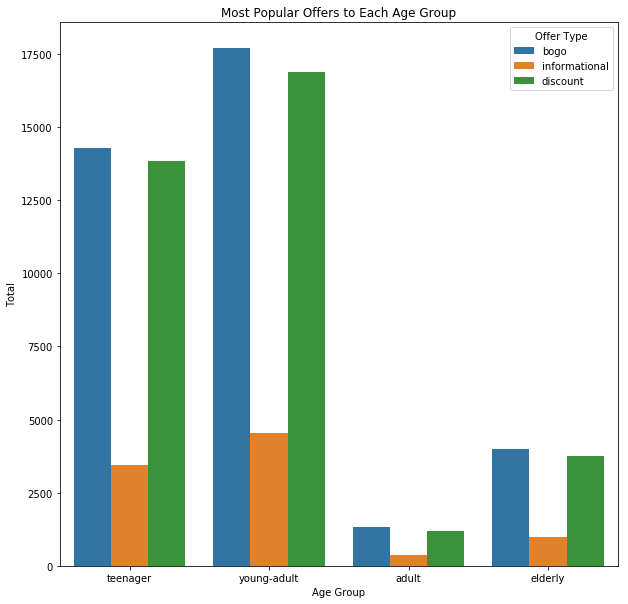

In [126]:
plt.figure(figsize=(10,10))
g = sns.countplot(x="age_group", hue="offer_type", data=merged_df)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

In [127]:
le.classes_=np.load('classes_gender.npy')
le.classes_


array(['F', 'M', 'O'], dtype=object)

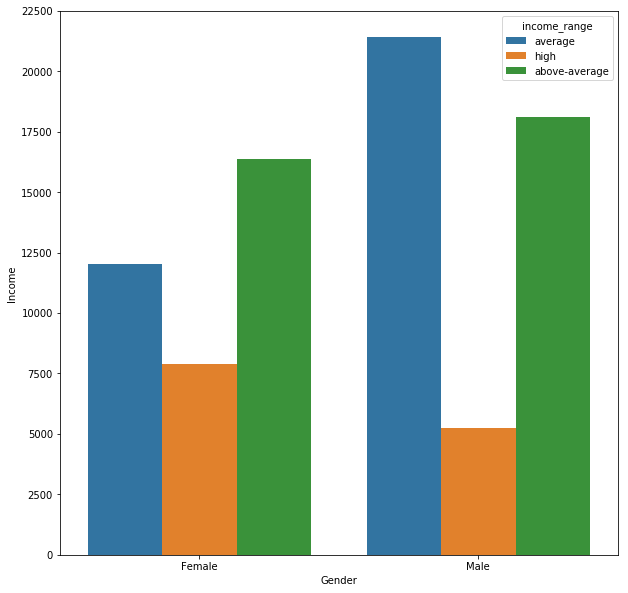

In [128]:
plt.figure(figsize=(10,10))
pt=sns.countplot(x='gender_cleaned',hue='income_range',data=merged_df[merged_df['gender_cleaned']!=2])
plt.ylabel('Income')
xlabels=['Female','Male']
pt.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

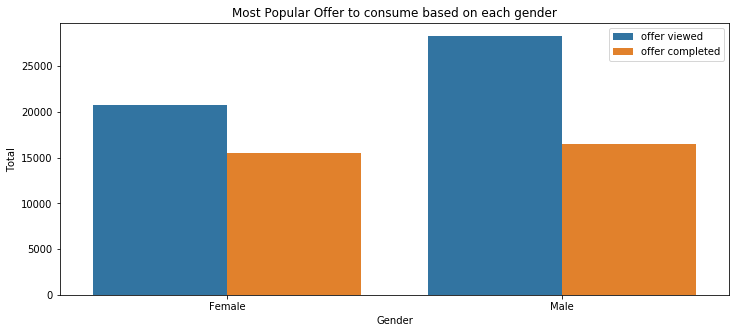

In [129]:
plt.figure(figsize=(12,5))

pt=sns.countplot(x='gender_cleaned',hue='event',data=merged_df[merged_df['gender_cleaned']!=2])
plt.title('Most Popular Offer to consume based on each gender')
plt.ylabel('Total')
xlabels=['Female','Male'] 
plt.xlabel('Gender')
pt.set_xticklabels(xlabels)
plt.legend()
plt.show()




In [130]:
avg_offer_consumed_gender=merged_df.groupby(['gender_cleaned','offer_id'])['time'].mean().reset_index()
print(avg_offer_consumed_gender[avg_offer_consumed_gender['gender_cleaned']==0]['time'].values[0],avg_offer_consumed_gender[avg_offer_consumed_gender['gender_cleaned']==0].values[0]/24)
print(avg_offer_consumed_gender[avg_offer_consumed_gender['gender_cleaned']==1]['time'].values[0],avg_offer_consumed_gender[avg_offer_consumed_gender['gender_cleaned']==1].values[0]/24)

406.024581006 [  0.           0.04166667  16.91769088]
405.108252947 [  0.04166667   0.04166667  16.87951054]


In [131]:
merged_df['became_member_onYear']=merged_df['became_member_onYear'].astype(int)

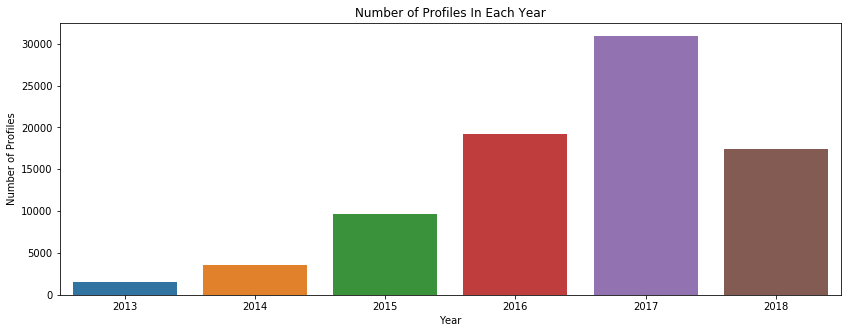

In [132]:
plt.figure(figsize=(14, 5))
sns.countplot(merged_df['became_member_onYear'])
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show()

In [133]:
(merged_df['became_member_onYear'].value_counts()/len(merged_df['became_member_onYear']))*100

2017    37.589911
2016    23.385255
2018    21.104685
2015    11.779500
2014     4.349728
2013     1.790921
Name: became_member_onYear, dtype: float64

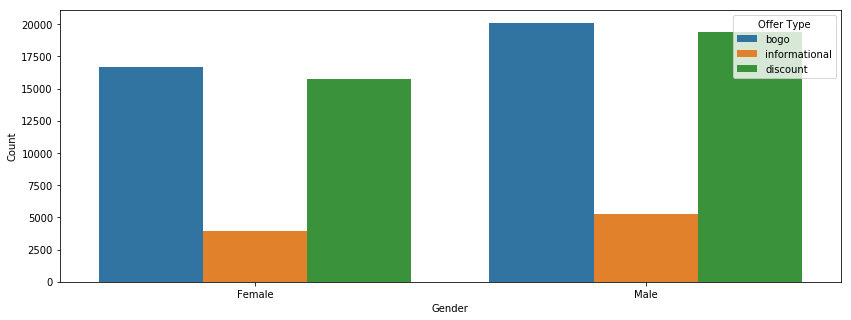

In [134]:
plt.figure(figsize=(14,5))
pt=sns.countplot(x='gender_cleaned',hue='offer_type',data=merged_df[merged_df['gender_cleaned']!=2])
plt.xlabel('Gender')
plt.ylabel('Count')
pt.set_xticklabels(['Female','Male'])
plt.legend(title='Offer Type')
plt.show()

In [135]:
trans_avg_time=merged_df.groupby(['cust_id','offer_id'])['time'].mean().reset_index()
trans_avg_time['time'].mean(),trans_avg_time['time'].mean()/24

(372.24939705130396, 15.510391543804332)

In [136]:
total_offers_types=merged_df[merged_df['gender_cleaned']!=2].groupby(['gender_cleaned','offer_type']).count()
total_offers_consumed=merged_df[merged_df['gender_cleaned']!=2].groupby(['gender_cleaned','event']).count()

total_offers_consumed

cust_id   time  offer_id  amount  reward_x  \
gender_cleaned event                                                         
0.0            offer completed    15477  15477     15477   15477     15477   
               offer viewed       20786  20786     20786   20786     20786   
1.0            offer completed    16466  16466     16466   16466     16466   
               offer viewed       28301  28301     28301   28301     28301   

                                event_cleaned  difficulty  duration  \
gender_cleaned event                                                  
0.0            offer completed          15477       15477     15477   
               offer viewed             20786       20786     20786   
1.0            offer completed          16466       16466     16466   
               offer viewed             28301       28301     28301   

                                offer_type  reward_y     ...       \
gender_cleaned event                                     ...        
0.0            offer completed       15477     15477     ...        
               offer viewed          20786     20786     ...        
1.0            offer completed       16466     16466     ...        
               offer viewed          28301     28301     ...        

                                became_member_onDay  \
gender_cleaned event                                  
0.0            offer completed                15477   
               offer viewed                   20786   
1.0            offer completed                16466   
               offer viewed                   28301   

                                became_member_onDayofweek  \
gender_cleaned event                                        
0.0            offer completed                      15477   
               offer viewed                         20786   
1.0            offer completed                      16466   
               offer viewed                         28301   

                                became_member_onDayofyear  \
gender_cleaned event                                        
0.0            offer completed                      15477   
               offer viewed                         20786   
1.0            offer completed                      16466   
               offer viewed                         28301   

                                became_member_onIs_month_end  \
gender_cleaned event                                           
0.0            offer completed                         15477   
               offer viewed                            20786   
1.0            offer completed                         16466   
               offer viewed                            28301   

                                became_member_onIs_month_start  \
gender_cleaned event                                             
0.0            offer completed                           15477   
               offer viewed                              20786   
1.0            offer completed                           16466   
               offer viewed                              28301   

                                became_member_onIs_quarter_end  \
gender_cleaned event                                             
0.0            offer completed                           15477   
               offer viewed                              20786   
1.0            offer completed                           16466   
               offer viewed                              28301   

                                became_member_onIs_quarter_start  \
gender_cleaned event                                               
0.0            offer completed                             15477   
               offer viewed                                20786   
1.0            offer completed                             16466   
               offer viewed                                28301   

                                became_member_onIs_year_end  \
gende

In [137]:
print('Females Offers Completed from offer viewed:',
      total_offers_consumed.loc[0].loc['offer completed'].values[0]
      /(total_offers_consumed.loc[0].loc['offer viewed'].values[0])*100,'%')

Females Offers Completed from offer viewed: 74.4587703262 %


In [138]:
print('Males Offers Completed from offer viewed:',
      total_offers_consumed.loc[1].loc['offer completed'].values[0]/
      (total_offers_consumed.loc[1].loc['offer viewed'].values[0])*100,'%')

Males Offers Completed from offer viewed: 58.1816896929 %


In [139]:
merged_df['event']

0           offer viewed
1           offer viewed
2           offer viewed
3           offer viewed
4           offer viewed
5           offer viewed
6        offer completed
7           offer viewed
8           offer viewed
9           offer viewed
12          offer viewed
13          offer viewed
14          offer viewed
16          offer viewed
17       offer completed
18          offer viewed
19          offer viewed
20          offer viewed
22          offer viewed
23       offer completed
25          offer viewed
29          offer viewed
30          offer viewed
31          offer viewed
32          offer viewed
33       offer completed
35          offer viewed
36          offer viewed
37       offer completed
38          offer viewed
              ...       
91270       offer viewed
91271    offer completed
91272    offer completed
91273    offer completed
91274    offer completed
91275    offer completed
91276    offer completed
91277    offer completed
91278       offer viewed


In [140]:
labels_event_mrgd = merged_df['event'].astype('category').cat.categories.tolist()
#generate offers to users

In [141]:
labels_event1 = merged_df['event'].astype('category').cat.categories.tolist()
replace_map_comp_event1 = {'event' : {k: v for k,v in zip(labels_event1,list(range(1,len(labels_event1)+1)))}}

labels_income1 = merged_df['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_range1 = {'income_range' : {k: v for k,v in zip(labels_income1,list(range(1,len(labels_income1)+1)))}}

labels_offer_type1 = merged_df['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type1 = {'offer_type' : {k: v for k,v in zip(labels_offer_type1,list(range(1,len(labels_offer_type1)+1)))}}


In [142]:
merged_df.replace(replace_map_comp_event1, inplace=True)
merged_df.replace(replace_map_comp_offer_type1, inplace=True)
merged_df.replace(replace_map_comp_income_range1, inplace=True)


In [143]:
merged_df['age_group']=le.fit_transform(merged_df['age_group'])

np.save('age_cleaned.npy',le.classes_)

In [144]:
merged_df.columns

Index(['event', 'cust_id', 'time', 'offer_id', 'amount', 'reward_x',
       'event_cleaned', 'difficulty', 'duration', 'offer_type', 'reward_y',
       'channel_email', 'channel_web', 'channel_mobile', 'channel_social',
       'age_group', 'income_range', 'gender_cleaned', 'became_member_onYear',
       'became_member_onMonth', 'became_member_onWeek', 'became_member_onDay',
       'became_member_onDayofweek', 'became_member_onDayofyear',
       'became_member_onIs_month_end', 'became_member_onIs_month_start',
       'became_member_onIs_quarter_end', 'became_member_onIs_quarter_start',
       'became_member_onIs_year_end', 'became_member_onIs_year_start',
       'member_type'],
      dtype='object')

In [145]:
x=merged_df[['time', 'offer_id', 'amount', 'reward_x',
        'difficulty', 'duration', 'offer_type', 'reward_y',
       'channel_email', 'channel_web', 'channel_mobile', 'channel_social',
       'age_group', 'income_range', 'gender_cleaned', 'became_member_onYear',
       'became_member_onMonth', 'became_member_onWeek', 'became_member_onDay',
       'became_member_onDayofweek', 'became_member_onDayofyear',
       'became_member_onIs_month_end', 'became_member_onIs_month_start',
       'became_member_onIs_quarter_end', 'became_member_onIs_quarter_start',
       'became_member_onIs_year_end', 'became_member_onIs_year_start',
       'member_type']]

y=merged_df[['event']]

In [146]:
pd.set_option('display.max_columns',None)
x.head()
np.sum(x.isna())


time                                0
offer_id                            0
amount                              0
reward_x                            0
difficulty                          0
duration                            0
offer_type                          0
reward_y                            0
channel_email                       0
channel_web                         0
channel_mobile                      0
channel_social                      0
age_group                           0
income_range                        0
gender_cleaned                      0
became_member_onYear                0
became_member_onMonth               0
became_member_onWeek                0
became_member_onDay                 0
became_member_onDayofweek           0
became_member_onDayofyear           0
became_member_onIs_month_end        0
became_member_onIs_month_start      0
became_member_onIs_quarter_end      0
became_member_onIs_quarter_start    0
became_member_onIs_year_end         0
became_membe

In [147]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [148]:
clf = RandomForestClassifier()
    
param_dist = {'n_estimators': [50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7]
                 }
    
    
grid_clf = GridSearchCV(clf, param_dist, cv=5, return_train_score=False)
    
grid_clf.fit(X_train, y_train)
preds=grid_clf.predict(X_test)
print(f'Accuracy of Random Forest classifier on testing set: {round(grid_clf.score(X_test, y_test)*100,2)}%.')
print(classification_report(y_test,preds))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

Accuracy of Random Forest classifier on testing set: 100.0%.
             precision    recall  f1-score   support

          1       1.00      1.00      1.00      8150
          2       1.00      1.00      1.00     12426

avg / total       1.00      1.00      1.00     20576



In [149]:

sv_clf=SVC()

sv_clf.fit(X_train,y_train)
preds=sv_clf.predict(X_test)
classification_report(y_test,preds)



/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'             precision    recall  f1-score   support\n\n          1       0.85      0.64      0.73      8150\n          2       0.79      0.93      0.85     12426\n\navg / total       0.82      0.81      0.80     20576\n'

In [150]:
sv_clf_lin=LinearSVC()

sv_clf_lin.fit(X_train,y_train)
preds=sv_clf_lin.predict(X_test)
classification_report(y_test,preds)


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'             precision    recall  f1-score   support\n\n          1       1.00      1.00      1.00      8150\n          2       1.00      1.00      1.00     12426\n\navg / total       1.00      1.00      1.00     20576\n'

### Second model
* Create a new df containg empty columns to calculate from it total_trans, trans_with_off and trans_num
* Iterate over cust_id and calulate the value for each new column
* Use get_trans_recs() to pull user data
* Add 1 to the related column, once there is an offer received, offer viewed and offer completed for the same offer with type BOGO or discount
* Add 0 to the related column, if all offers received, offer viewed are not completed at the end for the same offer with type BOGO or discount
* Add 1 to the related column, once there is an offer received, offer viewed and transaction happened within valid period of an offer with offer type informational
* Add 0 to the related column, if all offer received, offer viewed and no transaction happened within valid period of an offer with offer type informational
* Save new dataframe
* Train models

In [151]:
from collections import defaultdict


In [152]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [101]:
cols = portfolio.id.values
profile_trans = pd.DataFrame(np.nan, index = profile_cleaned.index.values, columns = cols)
cols_2 = ['trans_with_off','trans_num','trans_tot']
profile_trans2 = pd.DataFrame(np.zeros((profile.shape[0], 3)), index = profile.index.values, columns = cols_2)
profile_trans = pd.concat([profile_trans, profile_trans2], axis = 1)
profile_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,trans_with_off,trans_num,trans_tot
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [102]:
bogo_disc_offer_ids = portfolio[portfolio.offer_type.isin(['bogo', 'discount'])].id.values
bogo_disc_offer_ids

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [103]:
# function to pull each customer's transcripts
def get_trans_recs(customer_id):
    '''get personal transaction records in transcript data with personal id from profile data
    INPUT:
        customer_id(in): id from profile id
    
    OUTPUT:
        trans_recs(DataFrame): Personal transaction record
    '''
    trans_recs = transcript_cleaned[transcript_cleaned['cust_id'] == customer_id].reset_index(drop=True)
    return trans_recs

In [104]:
profile.head()
profile.shape[0]

17000

In [105]:
transcript_cleaned.head()

,event,cust_id,time,value,offer_id,amount,reward
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [106]:
profile_cleaned.head()

,cust_id,age_group,income_range,gender_cleaned,became_member_onYear,became_member_onMonth,became_member_onWeek,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,member_type
1,399,3,3,0,2017,7,28,15,5,196,False,False,False,False,False,False,1
3,7997,4,3,0,2017,5,19,9,1,129,False,False,False,False,False,False,2
5,15044,4,2,1,2018,4,17,26,3,116,False,False,False,False,False,False,1
8,3729,4,1,1,2018,2,6,9,4,40,False,False,False,False,False,False,1
12,3060,3,1,1,2017,11,45,11,5,315,False,False,False,False,False,False,1


In [107]:
tran_profile=transcript_cleaned.merge(profile_cleaned,how='left',on='cust_id')

In [108]:
tran_profile.head()

,event,cust_id,time,value,offer_id,amount,reward,age_group,income_range,gender_cleaned,...,became_member_onDay,became_member_onDayofweek,became_member_onDayofyear,became_member_onIs_month_end,became_member_onIs_month_start,became_member_onIs_quarter_end,became_member_onIs_quarter_start,became_member_onIs_year_end,became_member_onIs_year_start,member_type
0,offer received,7997,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,4.0,3.0,0.0,...,9.0,1.0,129.0,False,False,False,False,False,False,2.0
1,offer received,10736,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,15044,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,0,4.0,2.0,1.0,...,26.0,3.0,116.0,False,False,False,False,False,False,1.0
3,offer received,9525,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,6940,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
recs=get_trans_recs(3729).head()

In [110]:
recs['amount'].sum()
for offer in recs['event']:
    if offer =='offer completed':
        print(1)
    else:
        print(0)

0
0
0
1
0


In [111]:
cols = portfolio.id.values
profile_trans = pd.DataFrame(np.nan, index = profile.index.values, columns = cols)
profile_trans2 = pd.DataFrame(np.zeros((profile.shape[0], 3)), index = profile.index.values, columns = cols_2)
profile_trans=pd.concat([profile_trans,profile_trans2],axis=1)
profile_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,trans_with_off,trans_num,trans_tot
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [114]:
curr_ind = 0
for cus_ind in profile_cleaned['cust_id']:
    trans_recs=get_trans_recs(cus_ind)
    off_comp_times = defaultdict(int) # record times of offer complete after viewed  
    off_view_times = defaultdict(int) # record times of offer viewed before complete 
    receive_idx = trans_recs[trans_recs.event == 'offer received'].index.values # save all offer received event index
    trans_row = trans_recs[trans_recs.event == 'transaction'] # save all transaction events
    profile_trans.loc[curr_ind, 'trans_num'] = trans_row.shape[0] # save the number of transactions
    profile_trans.loc[curr_ind, 'trans_tot'] = trans_row.amount.sum() # save the total transaction value
    trans_offer_idx = []
    for receive_ind  in receive_idx:
        off_id=trans_recs.loc[receive_ind,'offer_id']
        off_hours=int(portfolio[portfolio['id']==off_id].duration)*24
        off_start = trans_recs.loc[receive_ind, 'time']
        off_end = off_start + off_hours        
        view_row=trans_recs[(trans_recs['offer_id']==off_id)&
                           (trans_recs['event']=='offer viewed')
                           &(trans_recs['time']>=off_start)&(trans_recs['time']<=off_end)]
        if view_row.shape[0] < 1:
            continue
        else:
            if off_id in bogo_disc_offer_ids:
                comp_off=trans_recs[(trans_recs['offer_id']==off_id)&
                           (trans_recs['event']=='offer completed')
                           &(trans_recs['time']>=off_start)&(trans_recs['time']<=off_end)]
                if comp_off.shape[0]<1:
                    off_view_times[off_id] +=1
                    off_comp_times[off_id] +=0
                else:
                    view_ind = view_row.index[0]
                    comp_ind = comp_row.index[0]
                    
                    if view_ind < comp_ind: # complete after view validly count
                        off_view_times[off_id] += 1
                        off_comp_times[off_id] += 1 # viewed and completed the offer
                        trans_offer_idx.extend(trans_row.loc[view_ind:comp_ind].index.values)
                    
                    else: # complete before view not count
                        continue
            else: # Informational offer
                view_time = view_row.iloc[0].time
                off_view_times[off_id] += 1
                info_trans_row = trans_recs[(trans_recs.time >= view_time) & 
                                            (trans_recs.time <= off_end) & 
                                            (trans_recs.event == 'transaction')]

                if info_trans_row.shape[0] > 0: # if there is transaction after view and before offer duration
                    off_comp_times[off_id] += 1 # effective offer                    
                else: 
                    off_comp_times[off_id] += 0 # ineffective offer                  
            
    for i in off_view_times.keys():
        # calculate effective rate of the offer on that customer
        profile_trans.loc[curr_ind, i] = round(off_comp_times[i] / off_view_times[i], 2)
    if len(trans_offer_idx) > 0: # calculate the sum of transaction driven by offer
        profile_trans.loc[curr_ind, 'trans_with_off'] = trans_row.loc[list(set(trans_offer_idx))].amount.sum()
    curr_ind+=1


In [115]:
profile_trans.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,trans_with_off,trans_num,trans_tot
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,76.0
1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,19.0,7.0,154.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0,56.0
3,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,9.0,3.0,35.0
4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,4.0,14.0


In [118]:
profile_trans.to_csv('profile_trans.csv')

In [4]:
profile_trans = pd.read_csv('profile_trans.csv', index_col = 'Unnamed: 0')

In [5]:
profile_trans['trans_avg'] = round(profile_trans['trans_tot'] / (profile_trans['trans_num']+0.001), 2) 
profile_trans['off_drive_ratio'] = round(profile_trans['trans_with_off'] / (profile_trans['trans_tot']+0.001), 2) 
profile_trans.drop(['trans_with_off', 'trans_num'], axis=1, inplace=True)

# keep gender in is not for training but for further illustration with figure
profile_trans = pd.concat([profile.loc[:, ['age', 'income', 'gender']], profile_trans], axis=1) 
profile_trans.columns = ['age', 'income', 'gender', 'offer_1', 'offer_2', \
                         'offer_3', 'offer_4', 'offer_5', 'offer_6', 'offer_7', 'offer_8',\
                         'offer_9', 'offer_10', 'trans_tot', 'trans_avg', 'off_drive_ratio']

In [6]:
profile_trans.head()

,age,income,gender,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,offer_10,trans_tot,trans_avg,off_drive_ratio
0,118,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,25.32,0.00
1,55,112000.0,F,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,154.0,22.00,0.12
2,118,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,56.0,18.66,0.00
3,75,100000.0,F,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,35.0,11.66,0.26
4,118,NaN,None,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,14.0,3.50,0.00


In [7]:
profile_trans=profile_trans[profile_trans['age']!=118]

In [8]:
profile_trans.iloc[0:5,-1]

1     0.12
3     0.26
5     0.00
8     0.00
12    0.00
Name: off_drive_ratio, dtype: float64

In [9]:
le= LabelEncoder()
le.classes_=np.load('classes_gender.npy')

In [10]:
le.classes_

array(['F', 'M', 'O'], dtype=object)

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
profile_trans['gender']=le.transform(profile_trans['gender'])

In [13]:
def classify_train_data(test_col, profile_trans = profile_trans):
    '''filter profile_trans data of customer with 1 or 0 score under dedicated offer id
    INPUT:
        test_col(str) - test data column name
        profile_trans(pandas DataFrame) - profile_trans dataframe
    OUTPUT:
        X(pandas DataFrame) - training data features
        y(pandas DataFrame) - training data label
    '''
    train_data = profile_trans[(profile_trans.loc[:,test_col] == 1) | \
                                  (profile_trans.loc[:,test_col] == 0)].loc[:, ['age','income','gender']]
    X, y = train_data.iloc[:,:3], train_data.iloc[:,-1]
    return X, y

def classify_grid_search(X, y):
    '''grid search and cross validation with estimator of random forest classifier 
    INPUT:
        X(pandas DataFrame) - training data features
        y(pandas DataFrame) - training data label
    OUTPUT:
        grid_clf(sklearn model instance) - trained model
    '''
    clf = RandomForestClassifier()
    
    param_dist = {'n_estimators': [50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7]
                 }
    
    
    grid_clf = GridSearchCV(clf, param_dist,refit = 'F1', cv=5, return_train_score=False)
    grid_clf.fit(X, y)
    
    return grid_clf

In [32]:
from sklearn.metrics import classification_report
clfs=[]
offer_list = profile_trans.columns[5:15]
for i, offer_num in enumerate(offer_list):
        
    X, y = classify_train_data(offer_num)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    grid_clf = classify_grid_search(X, y)
    clfs.append(grid_clf)
    preds=grid_clf.predict(x_test)
    print(classification_report(y_test,preds))




             precision    recall  f1-score   support

          0       1.00      1.00      1.00       187
          1       1.00      1.00      1.00       271
          2       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00       470

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        85
          1       1.00      1.00      1.00       120
          2       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00       209

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        72
          1       1.00      1.00      1.00        87
          2       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00       162

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       180
          1       1.00      1.00      1.00       211
          2       1.00      1.00    

In [33]:
def trans_personal_info_to_list(age, income, gender):
    '''Convert personal info to needed data shape for model predict
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 2 for female, 1 for male, 2 for other
    OUTPUT:
        person_info(numpy array): data structure fit to model predict
    '''

    p = [age, income]
    p.extend([gender])
    person_info = np.array(p).reshape(1,-1)
    return person_info

In [34]:


def pred_top_n_offer_with_person_info(age, income, gender, n=10, clfs=clfs):
    '''predict probability and return top n appropriate offer type with personal info 
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 'F' for female, 'M' for male, 'O' for other
        n(int): the number of top appropriate offer id in the return, from 1 to 10, default 10
        clfs(sklearn models): classifiers used to predict each offer's probability
    OUTPUT:
        top_n(list): top n offer ids with highest probability
    '''
    person_info = trans_personal_info_to_list(age, income, gender)
    pred_probs = []
    for i in range(10):
        prob = clfs[i].predict_proba(person_info)[0][1]
        pred_probs.append(prob)
        
    offer_prob = pd.Series(pred_probs, index=portfolio.id)
    if n > 10:
        n = 10
        
    sorted_offer_prob = offer_prob.sort_values(ascending=False)
    top_n = sorted_offer_prob.index.values[:n]
    return top_n

def pred_top_n_offer_with_cus_id(cus_id, clfs=clfs, n=10, profile_trans=profile_trans):
    '''
    predict probability and return top n appropriate offer type with customer id 
    INPUT:
        cus_id(str): customer id in profile_trans dataframe
        n(int): the number of top appropriate offer id in the return, default 10
        profile_trans(pandas DataFrame): used to get the customer's personal info
    OUTPUT:
        top_n(list): top n offer ids with highest probability
    '''
    if cus_id in profile_trans.index:
        age, income, gender = profile_trans.loc[cus_id][0:3]
        top_n = pred_top_n_offer_with_person_info(age, income, gender, n)
        return top_n
    else:
        print('Sorry no info for this user')


In [35]:
top_3 = pred_top_n_offer_with_person_info(55, 39,gender=0, n=3, clfs=clfs)
top_3

array(['fafdcd668e3743c1bb461111dcafc2a4',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [36]:
x_train_reg,x_test_reg,y_train_reg,y_test_reg=train_test_split(profile_trans.loc[:,['age','income','gender'
                                                                                   ]],profile_trans.loc[:,['trans_avg']],
                                                               test_size=0.2)


In [37]:
param_grid={
                    'n_estimators': [50, 100, 200],
                  'max_depth': [5, 7, 10, None],
                  'min_samples_split': [2, 5, 7, 10]
               
}

    
regressor=RandomForestRegressor()
cv=GridSearchCV(regressor,param_grid,n_jobs=-1)
cv.fit(x_train_reg,y_train_reg)

preds=cv.predict(x_test_reg)



/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

In [38]:
def pred_avg_ratio(age,income,gender,rgsr=cv):
    '''
    INPUT:
        age (int) :  age of the user between 18 and 101
        income (int) :  income of the user between 30000 to 120000
        gender (int) :  0 if user is Female 1 if the user is Male 2 if the user is Other
    OUTPUT:
        avg, ratio of user transactions
    
    '''
    user_info = trans_personal_info_to_list(age,income,gender)
    pred_results=[]
    pred=round(rgsr.predict(user_info)[0],2)
    pred_results.append(pred)
    return pred_results

def search_avg_ratio(cust_id,profile_trans=profile_trans):
    '''
    INPUT:
        CUST_ID, profile dataframe
    OUTPUT:
        avg ratio, ratio
    '''
    if cust_id in profile_trans.index:
        avg,ratio=profile_trans.loc[cust_id][-2:].values
        return [avg,ratio]
    else:
        print('Sorry no info for this user')
        
    
    

In [39]:
profile=profile[profile['age']!=118]
profile.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [40]:
m_68_70000 = pred_avg_ratio(68, 70000,1)
m_68_70000

[12.57]

### Finally combine two models


In [41]:
def offer_suggest(age,income, gender,n=5):
    '''
    INPUT:
        age (int) :  age of the user between 18 and 101
        income (int) :  income of the user between 30000 to 120000
        gender (int) :  0 if user is Female 1 if the user is Male 2 if the user is Other
        n (int) : number of offers to generate
    Output:
        offers : dataframe for the suggested offers based on user
        preds (list): customer transaction amount and offer drive ratio
    '''
    top_n = pred_top_n_offer_with_person_info(age,income,gender,n)
    offer = portfolio.set_index('id',drop=True).loc[top_n]
    preds = pred_avg_ratio(age,income,gender)
    
    return offer,preds
def offer_suggest_with_cus_id(cust_id,n=5):
    '''
    INPUT:
        cust_id (int) : User id transformed 
        n (int) : number of offers to generate
    Output:
        offers : dataframe for the suggested offers based on user
    '''
    if cust_id in profile_trans.index:
        top_n = pred_top_n_offer_with_person_info(cust_id,n)
        offer = portfolio.set_index('id',drop=True).loc[top_n]
        preds = search_avg_ratio(cust_id)
        return offer , preds

    else:
        print('Sorry no info for this user')

        
    
    
    

In [42]:
offers,preds = offer_suggest(68,70000,1,n=5)
offers

,channels,difficulty,duration,offer_type,reward
id,,,,,
4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,bogo,10
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2
5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3
0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,10,discount,5


# 3.Conclusion

### Application

* In this project we started by data visualization, and data cleaneing the combining datasets to create predicion models.

* A series of models was made to generate predictions on data 
    * the first model is to predict weather the user will compelete an offer or will view it
    * the second model was created to estimate the user average transactions 
    * the third and final model to predict most appropriate offer to generate for the user
    
### Flows

* The first model has a great accuracy with feature extracted from date feature. In addtion of some other feature as age, gender, income also the model must be feeded with new data every now and then as customer base change. And another data may have great significance on the model

* The second should be updated with new data evey nw and then since users age and income change the 3 selected features gives us great insight for the prediction model.

* The regression models perform not as well as classification models. The reason may come from that the data has not scattered well on the features provided. as the off_drive_ratio may depend on other values as occupation and other feature to make it more accurate

### Imporvements to add

* Adding how long the customer has been a user it will have some great results to maximize profit.

* Imporve regression model based on new features as date , weekday, weekend days etc.

* Push customer offer based on how long he/she been a client for starbucks











    